# Reanalysis preprocessing
***

__Author__: Chus Casado<br>
__Date__: 16-02-2024<br>

__Introduction__:<br>
This code processes the raw EFAS reanalysis discharge data to extract the data necessary for the following steps in the skill analysis.

The raw discharge data was downloaded from the Climate Data Store (CDS) and consists of NetCDF files for every year of the analysis. These NetCDF files contain values for the complete EFAS domain, but the succeeding analysis only require the time series for specific points: the selected reporting points. The code extracts these timeseries and saves the result in a folder of the repository.

In a second step, the discharge timeseries are compared against a discharge return period to create new binary time series of exceedance/non-exceedance over the specified discharge threshold. To account for events in which the peak discharge is close to the threshold, there's an option to create a 3-class exceedance timeseries: 0, non-exceendance; 1, exceedance over the reduced threshold ($0.95\cdot Q_{rp}$); 2, exceedance over the actual threshold ($Q_{rp}$). By default, the reducing factor is $0.95$, but this value can be changed in the parameter `reducing_factor` of the configuration file.

**To be improved**:<br>
* [ ] The extraction of the discharge time series and the thresholds for each stations is done with the Xarray function `da.sel(x=x, y=y, method='nearest')`, which is relatively slow. `lisflood-utilities` has a new function called `ncextract` that does the same computation more efficiently.

In [1]:
import os
path_root = os.getcwd()
import numpy as np
import pandas as pd
import xarray as xr
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import yaml
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path
import glob

path_root = os.getcwd()

os.chdir('../py/')
from config import Config
from plot.timeseries import plot_events_timeseries
os.chdir(path_root)

## 1 Configuration

In [3]:
config_path = Path('../conf')
config = Config.load_from_yaml(config_path / 'config_NWP_all_leadtimes.yml')

### 1.1 Reporting points

In [4]:
# area thresholds
min_area = config.reporting_points['area']
area_optimization = config.skill['area']

# paths
csv_stations = config.reporting_points['input']['CSV']
GIS_stations = config.reporting_points['input']['GIS']
path_out_stations = config.reporting_points['output']
path_out_stations.mkdir(parents=True, exist_ok=True)
file_out_stations = path_out_stations / f'reporting_points_over_{min_area}km2.parquet'

### 1.2 Discharge

In [5]:
# local directory where I have saved the raw discharge data
path_in = config.discharge['input']['reanalysis']

# start and end of the study period
start = config.discharge['study_period']['start']
end = config.discharge['study_period']['end']

# NetCDF file that contains the discharge thresholds for each reporting point
file_thresholds = config.discharge['return_period']['input']
# return period
rp = config.discharge['return_period']['threshold']
# percent buffer over the discharge threshold
reducing_factor = config.discharge['return_period']['reducing_factor']

## 2 Data

### 2.1 Reporting points

Load the table with all EFAS fixed reporting point and filter those points for which discharge data will be extracted.

In [12]:
# load table of fixed reporting points
stations = pd.read_csv(csv_stations, index_col='station_id')
# stations.index = stations.index.astype(str)
stations.index.name = 'id'

# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= min_area) & (stations.FixedRepPoint == True)
rename_columns = {'StationName': 'name',
                  'StationLon': 'lon',
                  'StationLat': 'lat',
                  'LisfloodX': 'X',
                  'LisfloodY': 'Y',
                  'DrainingArea.km2.LDD': 'area',
                  'Catchment': 'subcatchment',
                  'River': 'river',
                  'EC_Catchments': 'catchment',
                  'Country code': 'country',
                  'KGE': 'KGE',
                  'correlation': 'correlation',
                  'bias': 'bias',
                  'variability': 'variability'}
stations = stations.loc[mask, rename_columns.keys()]
stations.rename(columns=rename_columns, inplace=True)
stations[['strahler', 'pfafstetter']] = np.nan

***

```python
rendimiento = pd.read_csv('../data/reporting_points/indexes_ltr_efas4.csv', usecols=['ObsID', 'KGE', 'KGE_r', 'KGE_B', 'KGE_y'], index_col='ObsID')

stations.shape, rendimiento.shape

stations[['KGE', 'correlation', 'bias', 'variability']] = rendimiento.round(3)
stations.index.name = 'station_id'

stations.head()

stations.to_csv('../data/reporting_points/Station-2022-10-27v12_KGE.csv')
```

***

In [15]:
# load shapefile with edited river and catchment names
points_edited = gpd.read_file(GIS_stations)
points_edited.set_index('station_id', inplace=True, drop=True)
points_edited.index = points_edited.index.astype(int)
points_edited = points_edited[['StationNam', 'LisfloodX', 'LisfloodY', 'DrainingAr', 'Subcatchme',
                               'River', 'Catchment', 'Country co', 'strahler', 'pfafstette']]
points_edited.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country', 'strahler', 'pfafstetter']
points_edited['KGE'] = np.nan
# select points with a Pfafstetter code
mask = points_edited.pfafstetter.isnull()
points_edited = points_edited.loc[~mask]

In [16]:
# correct names of catchments and rivers
ids = list(set(stations.index).intersection(points_edited.index))
stations = stations.loc[ids]
for id in ids:
    for col in ['subcatchment', 'river', 'catchment']:
        if points_edited.loc[id, col] != np.nan:
            stations.loc[id, col] = points_edited.loc[id, col]

# add subcatchment and river order
stations.loc[ids, ['strahler', 'pfafstetter']] = points_edited.loc[ids, ['strahler', 'pfafstetter']]

print('no. stations:\t{0}'.format(stations.shape[0]))

no. stations:	2371


In [17]:
# xarrys with station coordinates that will be used to extract data
x = xr.DataArray(stations.X, dims='id')
y = xr.DataArray(stations.Y, dims='id')

### 2.2 Discharge data

It loads the EFAS discharge reanalyses for the complete EFAS domain, and out of if only it extracts the discharge time series for the previously selected reporting points and the study period. The discharge timeseries are saved in a _parquet_ file.

In [19]:
var = 'discharge'

# output folder
path_out = config.get(var)['output']['reanalysis']
path_out.mkdir(parents=True, exist_ok=True)

# load dataset and extract variable discharge
files = glob.glob(f'{path_in}/*.nc')
years = [str(year) for year in range(start.year, end.year + 1)]
files = [file for file in files if any(year in file for year in years)]
dis = xr.open_mfdataset(files)['dis06']
dis.close()

# trim data to the study period
dis = dis.sel(time=slice(start, end))

# extract discharge for the selected stations
dis = dis.sel(x=x, y=y, method='nearest')
dis = dis.drop(['x', 'y', 'step', 'surface', 'latitude', 'longitude', 'valid_time'])

# compute the lazy DataArray
dis = dis.compute()

# add 6 h to the timesteps
dis = dis.rename({'time': 'datetime'})
dis['datetime'] = dis.datetime + np.timedelta64(6, 'h')

# save extraction as NetCDF files
dis.name = var
for stn in tqdm(dis.id.data):
    dis.sel(id=stn).to_netcdf(path_out / f'{stn:>04}.nc')

  0%|          | 0/2371 [00:00<?, ?it/s]

### 2.3 Discharge thresholds

The discharge thresholds are the discharge values for return periods 1.5, 2, 5, 10, 20, 50, 100, 200 and 500 years. The data is supplied in a NetCDF file that contains all the river network in Europe. This NetCDF is loaded as an _xarray_ and the values corresponding to the selected reporting points are extracted.

In [20]:
# load thresholds
thresholds = xr.open_dataset(file_thresholds)

# extract thresholds for the selected stations
thresholds = thresholds.sel(x=x, y=y, method='nearest')
thresholds = thresholds.drop(['x', 'y'])

# add thresholds to the DataFrame of stations
for var, da in thresholds.items():
    stations.loc[thresholds.id, var] = da.values.round(1)

## 3 Analysis: exceedance over threshold

This block of code computes the exceedances of the X-year return period out of the discharge timeseries and thresholds that were previously extracted. The results are seved in a _parquet_ file that will be used in the succeeding analys.

In [21]:
var = 'exceedance'

# compute exceedance
thr = f'rl{rp}'
exceedance = dis >= thresholds[thr]
if reducing_factor is not None:
    # compute exceendance over the reduced threshold
    exceedance_buffer = dis >= thresholds[thr] * (1 - reducing_factor)
    
    # create a 3-class exceedance DataArray:
    # 0: non-exceedance
    # 1: exceeedance over the reduced threshold
    # 2: exceedance over the threshold
    exceedance = np.maximum(exceedance.astype(int) * 2, exceedance_buffer.astype(int))

# output folder
path_out = path_out = config.get(var)['output']['reanalysis'] / f'{rp}'
path_out.mkdir(parents=True, exist_ok=True)

# save as NetCDF files
exceedance.name = var
for stn in tqdm(exceedance.id.data):
    exceedance.sel(id=stn).to_netcdf(path_out / f'{stn:>04}.nc')

  0%|          | 0/2371 [00:00<?, ?it/s]

### 3.1 Duration of events

In this section we will analyse the distribution of the duration of the events.

In [22]:
# make sure that the exceedance DataArray is binary
exceedance_bi = exceedance.copy()
exceedance_bi = exceedance_bi.where(exceedance_bi == 2, other=0)
exceedance_bi = exceedance_bi.where(exceedance_bi == 0, other=1)

# find the onset of the events
onsets =  xr.concat((exceedance_bi.isel(datetime=0).astype(bool), exceedance_bi.diff('datetime')), dim='datetime') == 1
onsets = onsets.sel(datetime=slice(start, end))

# find the offset of the events
offsets = xr.concat((exceedance_bi.isel(datetime=0).astype(bool), exceedance_bi.diff('datetime')), dim='datetime') == -1
offsets = offsets.sel(datetime=slice(start, end))

# count number of events
col_events = f'obs_events_{rp}'
stations[col_events] = onsets.sum('datetime').to_pandas()

# export DataFrame of stations
stations.to_parquet(file_out_stations)

In [25]:
# evaluate the duration (in hours) of each event
event_durations = {}
for stn in tqdm(onsets.id.data):
    if stations.loc[stn, col_events] == 0:
        continue
    # dates of the onsets and offsets of the events
    dates_onsets = onsets.sel(id=stn).where(onsets.sel(id=stn), drop=True).datetime.data
    dates_offsets = offsets.sel(id=stn).where(offsets.sel(id=stn), drop=True).datetime.data
    # corrections in case the amount of onsets and onsets don't match
    if len(dates_onsets) > len(dates_offsets):
        dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    elif len(dates_onsets) < len(dates_offsets):
        dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
    # correction in case the first onset is later that the first offset
    else:
        if dates_onsets[0] > dates_offsets[0]:
            print(stn)
            dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
            dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    # convert into hours
    durations = (dates_offsets - dates_onsets) / np.timedelta64(1, 'h')
    event_durations[stn] = durations

  0%|          | 0/2371 [00:00<?, ?it/s]

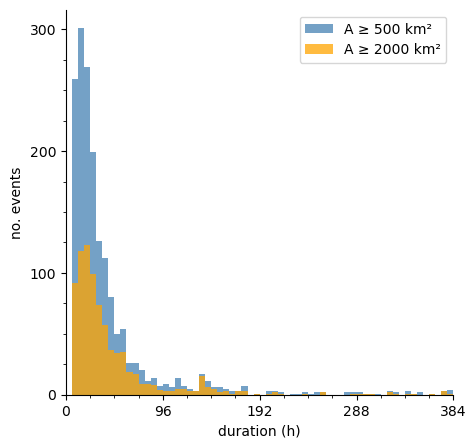

In [26]:
# convert dictionary of durations into a flattened array
durations_all = []
durations_opt = []
for stn, arr in event_durations.items():
    for d in arr:
        durations_all.append(d)
        if stations.loc[stn, 'area'] >= area_optimization:
            durations_opt.append(d)
durations_all = np.array(durations_all)
durations_opt = np.array(durations_opt)

# plot distribution of event duration

xmin = 0
xmax = 16 * 24
bins = np.arange(xmin, xmax + 1, 6).astype(int)

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(durations_all, ax=ax, bins=bins, color='steelblue', edgecolor=None, label=f'A ≥ {min_area} km²')
sns.histplot(durations_opt, ax=ax, bins=bins, color='orange', edgecolor=None, label=f'A ≥ {area_optimization} km²')
ax.set(xlabel='duration (h)', ylabel='no. events', xlim=(xmin, xmax));
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(96))
ax.xaxis.set_minor_locator(MultipleLocator(24))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend();

plt.savefig(path_out / 'duration_distribution.jpg', dpi=300, bbox_inches='tight')

***Figure 1**. Distribution of the duration of the "observed" flood events. Every bin corresponds to 6 h, i.e., the time step resolution of the simultion. Blue represents all the reporting points included in the analysis, and red the reporting points that will be used in the optimization of the notification criteria.*

The figure above shows that the majority of events have a duration shorter than 2 days, both for the complete set of reporting points (82%) and the set that will be used in the optimization (79%). In the first set these events account for 82%. The mode in the duration is either 12 or 18 h for the complete and the optimization sets, respectively. Even though the number of events is reduced to a half between the 500 and the 2000 km² threshold, the distribution of the event duration is fairly similar.